In [1]:
library(plyr);      
library(caret);     
library(dplyr);     
library(gridExtra)

inpath  <- "C:\Users\yinghe\pyworkspace\KaggleTita";
outpath <- "C:\Users\yinghe\pyworkspace\KaggleTita";

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [5]:
train <- read.csv("train.csv");
test  <- read.csv("test.csv");

In [6]:
test$Survived <- NA;
test$Set  <- "Test";
train$Set <- "Train";
comb <- rbind(train, test);
test_index <- comb %>% filter(Set=="Test") %>% .$PassengerId

In [7]:
comb$Survived <- factor(comb$Survived)

In [9]:
comb$FareFac <- factor(comb$Fare); 
trControl <- trainControl(method="repeatedcv", number=7, repeats=5); 
faremiss <- which(is.na(comb$Fare)); # missing fares (only PassengerId = 1044 is missing)
model_f   <- train( FareFac ~ Pclass + Sex + Embarked + SibSp + Parch, data = comb,
                   trControl = trControl, method="rpart", na.action = na.pass);
print(model_f$results)

Loading required package: rpart
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

          cp   Accuracy      Kappa AccuracySD    KappaSD
1 0.01923077 0.17445932 0.14272943 0.01659687 0.01798928
2 0.02043269 0.14855847 0.11199917 0.01547620 0.01982793
3 0.04366987 0.08428029 0.04058209 0.03919371 0.04245693


In [10]:
comb$FareFac[faremiss] = predict(model_f, comb[faremiss,]); 
comb$Fare[faremiss] <- as.numeric(as.character(comb$FareFac[faremiss]));


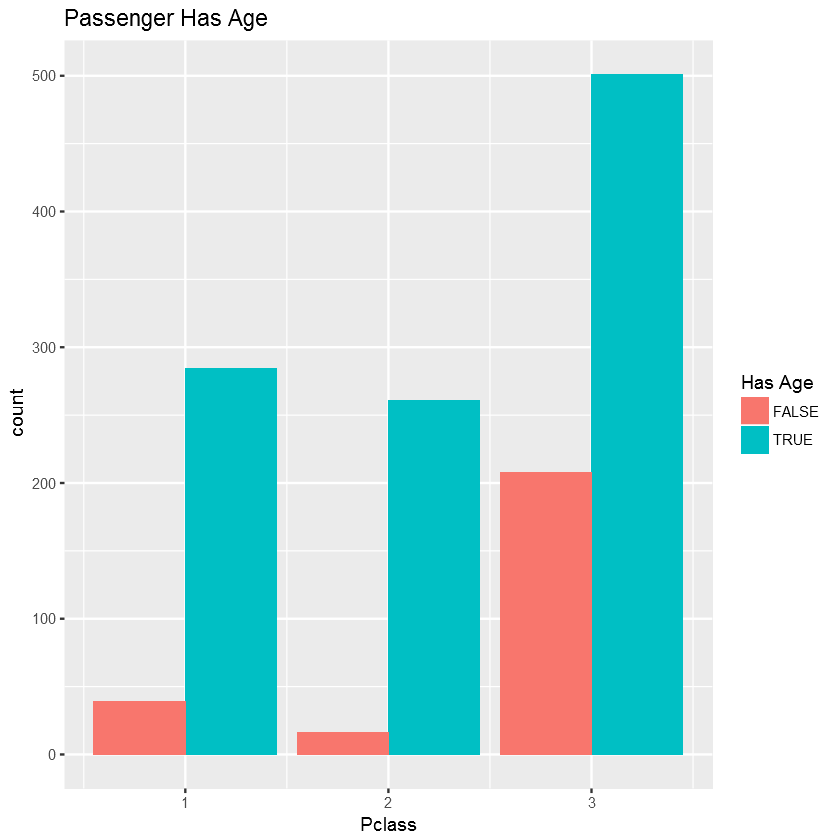

In [11]:
ggplot(comb, aes(Pclass,fill=!is.na(Age))) + geom_bar(position="dodge") + labs(title="Passenger Has Age",fill="Has Age")

Warning message:
"Removed 41 rows containing non-finite values (stat_density)."

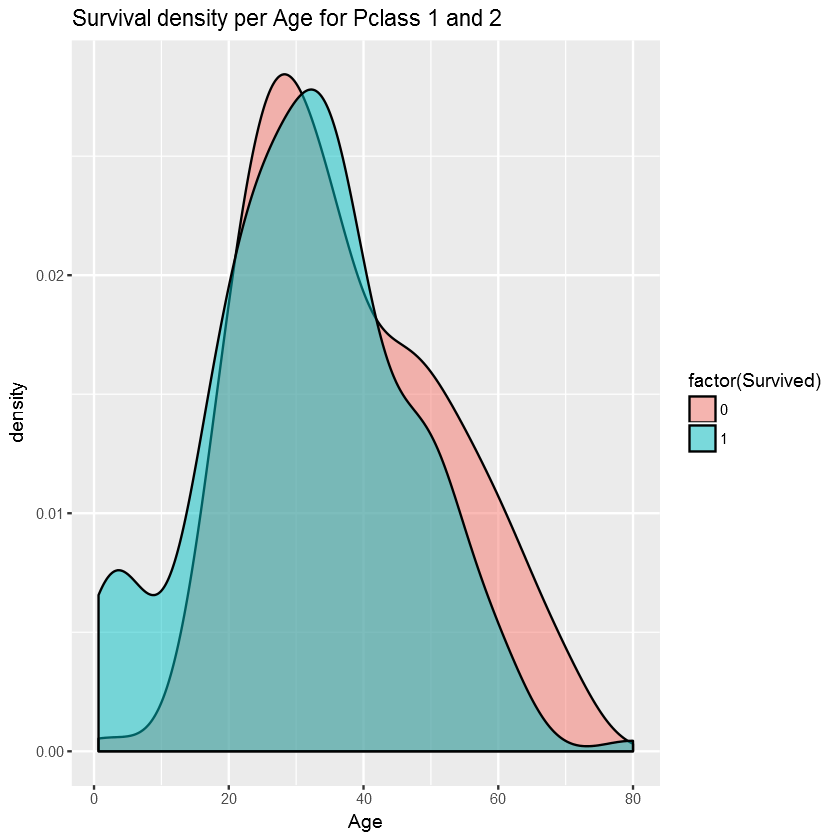

In [12]:
ggplot(comb %>% filter(Set=="Train", Pclass!=3), aes(Age)) + 
  geom_density(alpha=0.5, aes(fill=factor(Survived))) + labs(title="Survival density per Age for Pclass 1 and 2");

In [13]:
child <- 14;
comb$Minor <- ifelse(comb$Age<child&comb$Pclass!=3, 1, 0);
comb$Minor <- ifelse(is.na(comb$Minor), 0, comb$Minor);

In [14]:
comb$TFreq <- ave(seq(nrow(comb)), comb$Ticket,  FUN=length);
comb$FFreq <- ave(seq(nrow(comb)), comb$FareFac, FUN=length);
comb$CFreq <- ave(seq(nrow(comb)), comb$Cabin,   FUN=length);

In [15]:
comb$Surname <- sapply(as.character(comb$Name), FUN=function(x) {strsplit(x, split='[,.]')[[1]][1]});

In [16]:
print(comb %>% filter(Fare=="6.75"))

  PassengerId Survived Pclass                         Name    Sex Age SibSp
1         144        0      3          Burke, Mr. Jeremiah   male  19     0
2         655        0      3 Hegarty, Miss. Hanora "Nora" female  18     0
  Parch Ticket Fare Cabin Embarked   Set FareFac Minor TFreq FFreq CFreq
1     0 365222 6.75              Q Train    6.75     0     1     2  1014
2     0 365226 6.75              Q Train    6.75     0     1     2  1014
  Surname
1   Burke
2 Hegarty


In [17]:
comb$GID <- rep(NA, nrow(comb));
maxgroup <- 12; # maximum size of a group
for ( i in comb$PassengerId) {
    if(comb$SibSp[i] + comb$Parch[i] > 0) { # Check first if ID has relatives 
        comb$GID[i] <- paste0(comb$Surname[i], comb$SibSp[i] + comb$Parch[i]);  
    } else {
        if(comb$TFreq[i] > 1 & is.na(comb$GID[i])) { # Next if shares ticket number with others 
            comb$GID[i] <- as.character(comb$Ticket[i]);
        } else {
            if(comb$CFreq[i] > 1 & comb$CFreq[i]<maxgroup & is.na(comb$GID[i])) { # Next if shares cabin with others
                    comb$GID[i] <- as.character(comb$Cabin[i]);
            }
            else {
                if(comb$FFreq[i] > 1 & comb$FFreq[i]<maxgroup & is.na(comb$GID[i])) { # Next if shares Fare value with others
                    comb$GID[i] <- as.character(comb$FareFac[i]);
                } else { 
                    comb$GID[i] <- "Single"; # Individual doesn't belong to any group
                }
            }
        }   
    }
}
comb$GID <- factor(comb$GID);

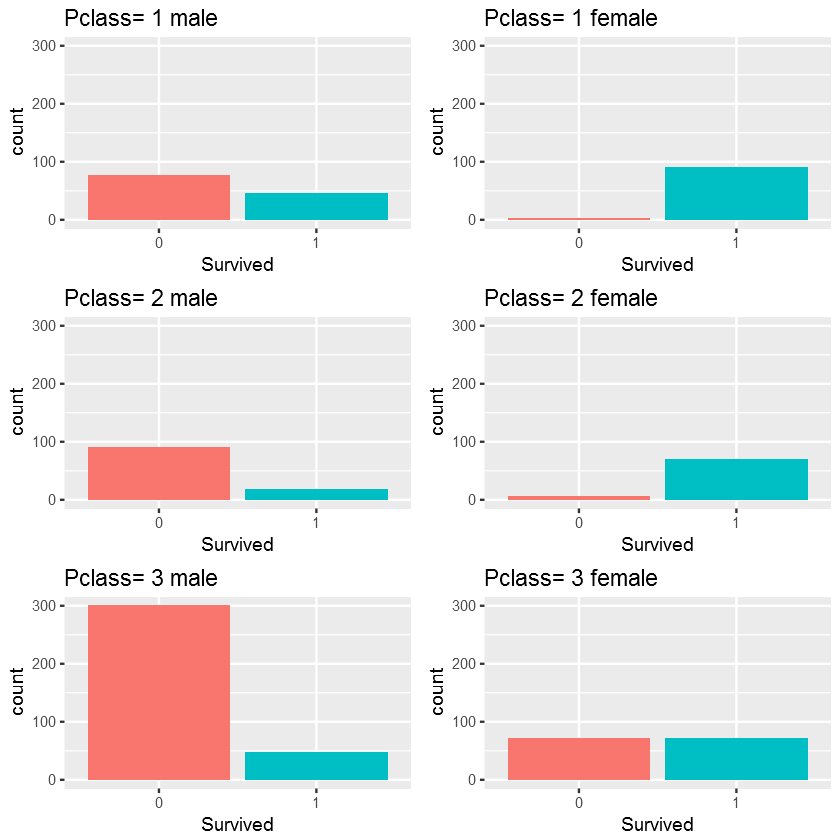

In [18]:
comb$SLogL <- rep(0,nrow(comb));
# define function to compute log likelihood of a/(1-a)
logl <- function(a) {
    a <- max(a,0.1); # avoids log(0)
    a <- min(a,0.9); # avoids division by 0
    return (log(a/(1-a)));
}
p <- list();
item <- 1;
ylim <- 300;
for(class in c(1:3)){
    for(sex in c("male", "female")) {
        p[[item]] <- ggplot(comb %>% filter(Set=="Train", Pclass==class, Sex==sex), aes(x=Survived)) + 
          geom_bar(aes(fill=Survived)) + scale_y_continuous(limits=c(0,ylim)) + 
          theme(legend.position="none") + labs(title=paste('Pclass=', as.character(class), sex));
        item <- item + 1;
    }
}
do.call(grid.arrange, p)

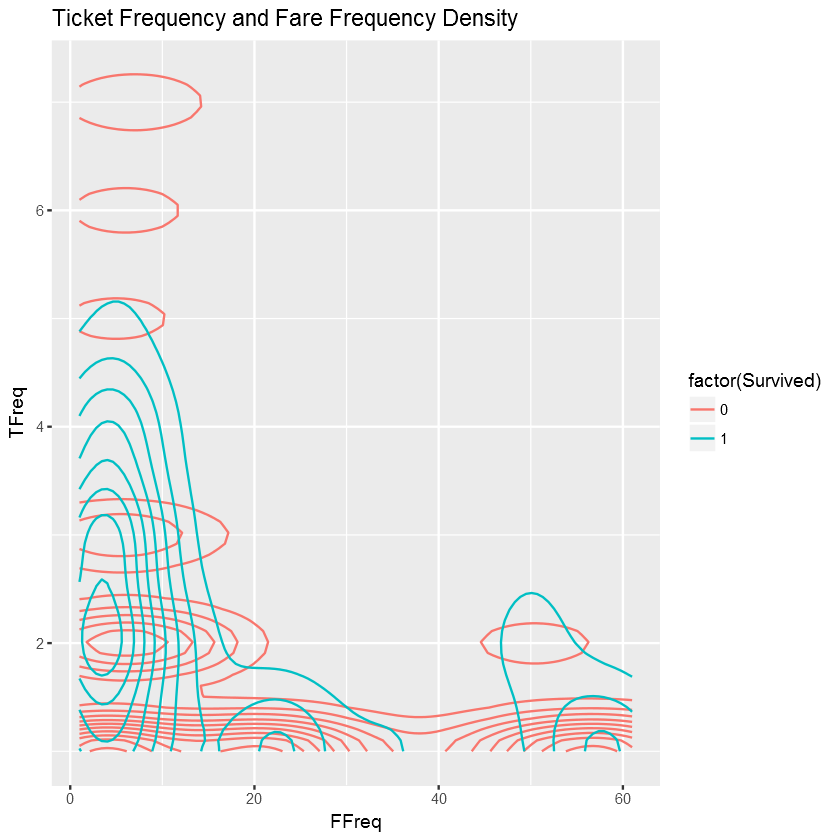

In [19]:
for (sex in c("male", "female")) {
    for (class in c(1:3)) {
        comb$SLogL[comb$Sex==sex& comb$Pclass==class] <- 
            logl(nrow(comb %>% filter(Survived==1, Sex==sex, Pclass==class))/nrow(comb %>% filter(Set=="Train", Sex==sex, Pclass==class)));
    }
}
ggplot(comb %>% filter(Set=="Train"), aes(x=FFreq, y=TFreq, color=factor(Survived))) +
  geom_density_2d() + labs(title="Ticket Frequency and Fare Frequency Density");

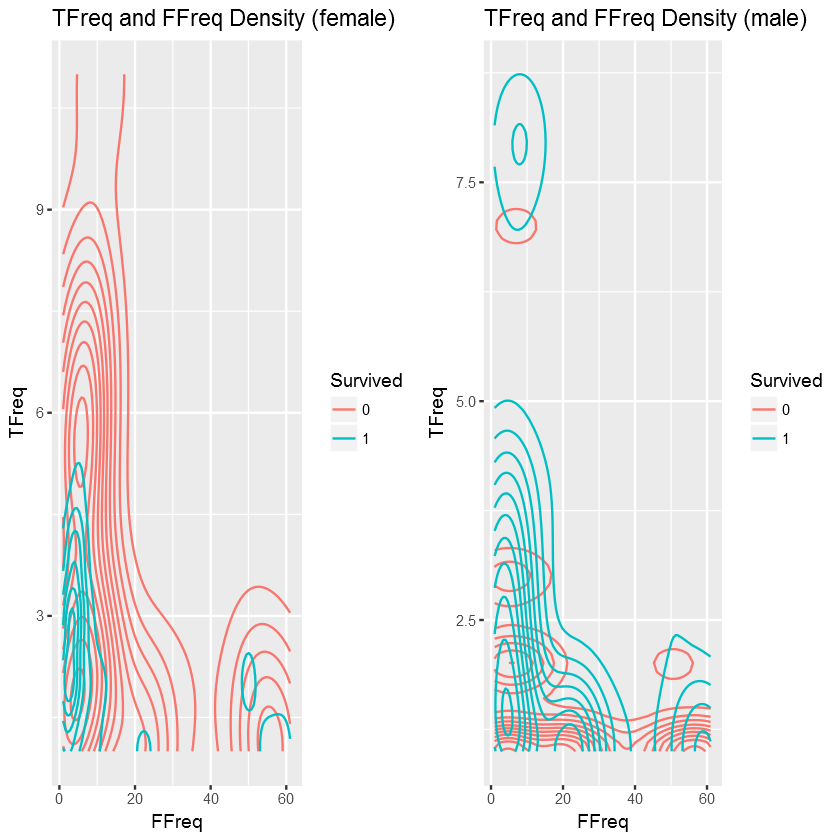

In [20]:
pf <- ggplot(comb %>% filter(Set=="Train",Sex=='female'), aes(x=FFreq, y=TFreq, color=Survived)) +
  geom_density_2d() + labs(title="TFreq and FFreq Density (female)");
pm <- ggplot(comb %>% filter(Set=="Train",Sex=="male"), aes(x=FFreq, y=TFreq, color=Survived)) +
  geom_density_2d() + labs(title="TFreq and FFreq Density (male)");
grid.arrange(pf, pm, ncol=2);

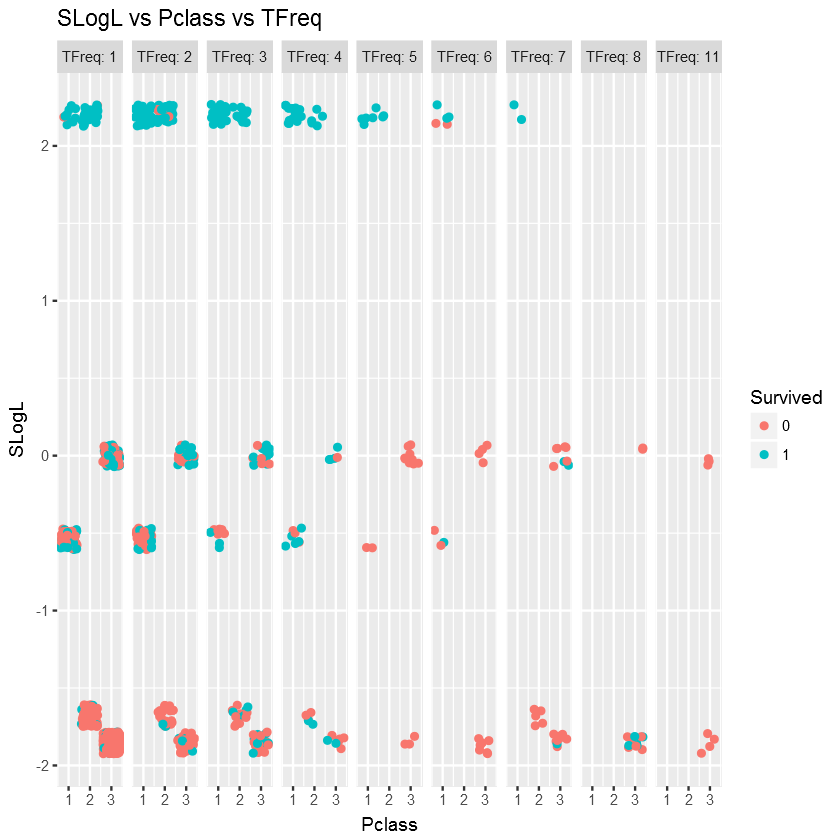

In [21]:
ggplot(comb %>% filter(Set=="Train"), aes(x=Pclass, y=SLogL)) + geom_jitter(aes(color=Survived)) + 
  facet_grid(  . ~ TFreq,  labeller=label_both) + labs(title="SLogL vs Pclass vs TFreq")

Warning message:
"position_dodge requires non-overlapping x intervals"

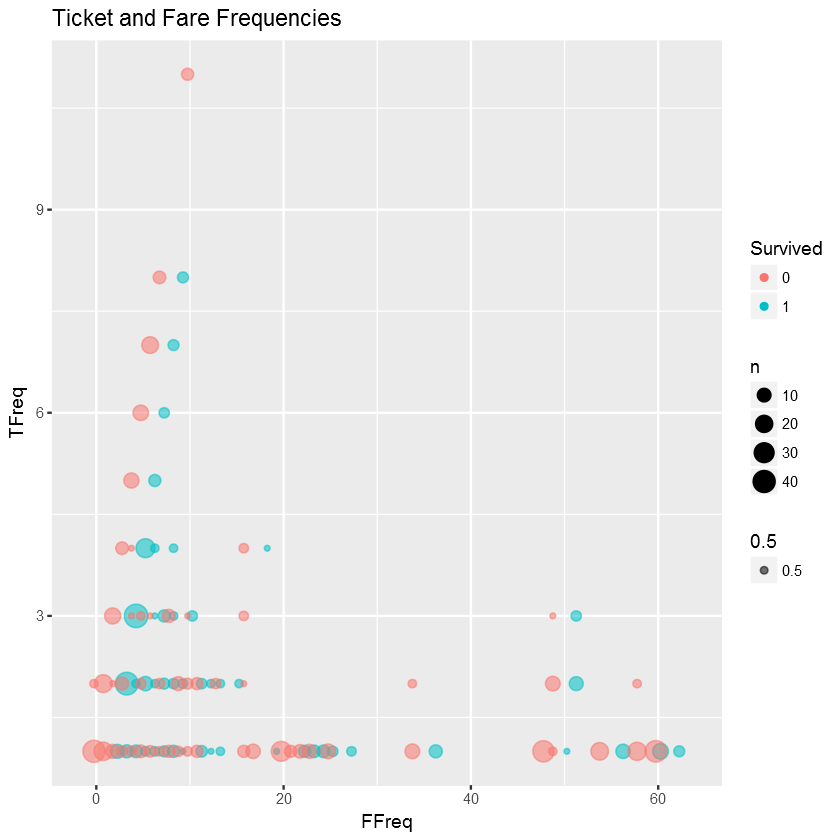

In [22]:
ggplot(comb %>% filter(Set=="Train"), aes(x=FFreq, y=TFreq, color=Survived, alpha=0.5)) +
  geom_count(position=position_dodge(width=5)) + labs(title="Ticket and Fare Frequencies");

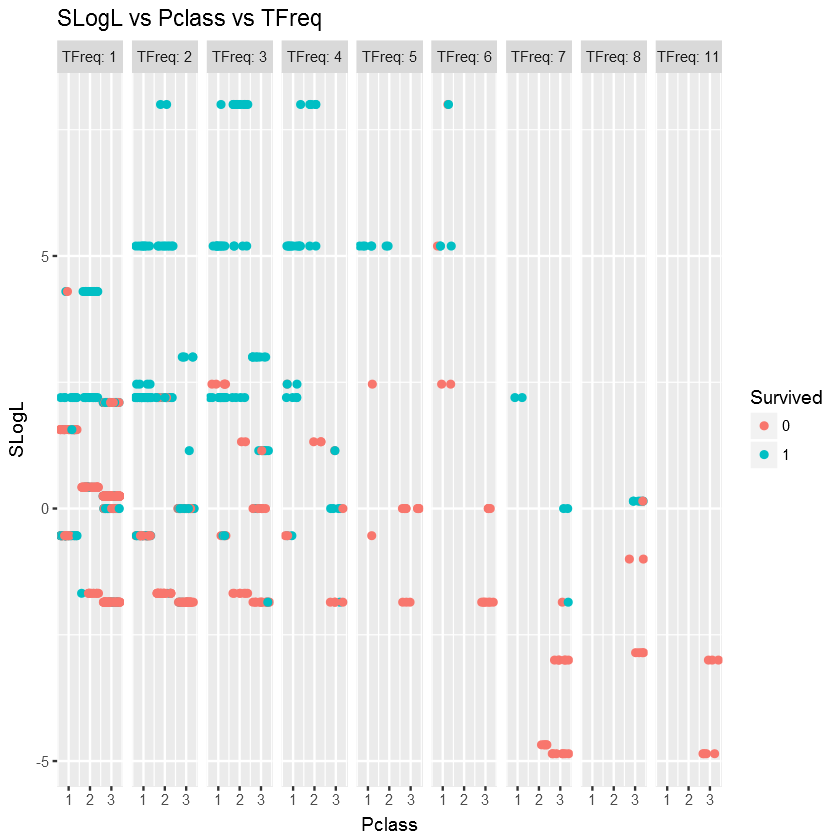

In [23]:
ticket_stats <- comb %>% group_by(Ticket) %>% summarize(l = length(Survived), na = sum(is.na(Survived)), c = sum(as.numeric(Survived)-1, na.rm=T));
for ( i in 1:nrow(ticket_stats)) {
    plist <- which(comb$Ticket==ticket_stats$Ticket[i]);
    if(ticket_stats$na[i] > 0 & ticket_stats$l[i] > 1 & ticket_stats$c[i] > 0) {
            comb$SLogL[plist] <- comb$SLogL[plist] + 3;
    }
}
sconst <- -2.1;
comb$SLogL[comb$GID=="Single"] <- comb$SLogL[comb$GID=="Single"] - sconst;
comb$SLogL[comb$TFreq ==  7] <- comb$SLogL[comb$TFreq == 7]  - 3;
comb$SLogL[comb$TFreq ==  8] <- comb$SLogL[comb$TFreq == 8]  - 1;
comb$SLogL[comb$TFreq == 11] <- comb$SLogL[comb$TFreq == 11] - 3;
comb$SLogL[comb$Minor==1] <- 8;
ggplot(comb %>% filter(Set=="Train"), aes(x=Pclass, y=SLogL)) + geom_jitter(aes(color=Survived)) + 
  facet_grid(  . ~ TFreq,  labeller=label_both) + labs(title="SLogL vs Pclass vs TFreq")

In [24]:
set.seed(1);
trControl <- trainControl(method="repeatedcv", number=7, repeats = 5); 
fms <- formula("Survived ~ SLogL"); 
model_m <- train(fms, data = comb %>% filter(Set=="Train"),
     metric="Accuracy", trControl = trControl, method = "knn"); 
comb$Pred <- predict(model_m, comb);
print(model_m$results)

  k  Accuracy     Kappa AccuracySD    KappaSD
1 5 0.8226193 0.6055714 0.02824760 0.06593707
2 7 0.8190232 0.5960192 0.02881039 0.06736601
3 9 0.8163288 0.5898263 0.02841436 0.06590235


In [31]:
df_final <- data.frame(PassengerId = comb$PassengerId[test_index], Survived=comb$Pred[test_index])
print(df_final)

    PassengerId Survived
1           892        0
2           893        0
3           894        0
4           895        0
5           896        1
6           897        0
7           898        0
8           899        0
9           900        1
10          901        0
11          902        0
12          903        0
13          904        1
14          905        0
15          906        1
16          907        1
17          908        0
18          909        0
19          910        0
20          911        1
21          912        0
22          913        0
23          914        1
24          915        0
25          916        1
26          917        0
27          918        1
28          919        0
29          920        0
30          921        0
31          922        0
32          923        0
33          924        1
34          925        0
35          926        0
36          927        0
37          928        1
38          929        1
39          930        0


In [ ]:
# write.csv(df_final,file="pred_R.csv")